<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-|-Introduction-" data-toc-modified-id="1-|-Introduction--1"><b><span style="color:#761D80">1 |</span><span style="color:#761D80"> Introduction </span></b></a></span></li><li><span><a href="#2-|-Libraries-" data-toc-modified-id="2-|-Libraries--2"><b><span style="color:#761D80">2 |</span><span style="color:#761D80"> Libraries </span></b></a></span></li><li><span><a href="#3-|-Загрузка-и-первичное-исследование-данных-" data-toc-modified-id="3-|-Загрузка-и-первичное-исследование-данных--3"><b><span style="color:#761D80">3 |</span><span style="color:#761D80"> Загрузка и первичное исследование данных </span></b></a></span><ul class="toc-item"><li><span><a href="#Table-data_arc" data-toc-modified-id="Table-data_arc-3.1"><strong><span style="color:#6C91BF">Table data_arc</span></strong></a></span></li><li><span><a href="#Table-data_bulk" data-toc-modified-id="Table-data_bulk-3.2"><strong><span style="color:#6C91BF">Table data_bulk</span></strong></a></span></li><li><span><a href="#Table-data_bulk_time" data-toc-modified-id="Table-data_bulk_time-3.3"><strong><span style="color:#6C91BF">Table data_bulk_time</span></strong></a></span></li><li><span><a href="#Table-data_gas" data-toc-modified-id="Table-data_gas-3.4"><strong><span style="color:#6C91BF">Table data_gas</span></strong></a></span></li><li><span><a href="#Table-data_temp" data-toc-modified-id="Table-data_temp-3.5"><strong><span style="color:#6C91BF">Table data_temp</span></strong></a></span></li><li><span><a href="#Table-data_wire" data-toc-modified-id="Table-data_wire-3.6"><strong><span style="color:#6C91BF">Table data_wire</span></strong></a></span></li><li><span><a href="#Table-data_wire_time" data-toc-modified-id="Table-data_wire_time-3.7"><strong><span style="color:#6C91BF">Table data_wire_time</span></strong></a></span></li></ul></li><li><span><a href="#4-|-Data-pre-processing-" data-toc-modified-id="4-|-Data-pre-processing--4"><b><span style="color:#761D80">4 |</span><span style="color:#761D80"> Data pre-processing </span></b></a></span></li><li><span><a href="#5-|-Model-training-" data-toc-modified-id="5-|-Model-training--5"><b><span style="color:#761D80">5 |</span><span style="color:#761D80"> Model training </span></b></a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-5.1"><strong><span style="color:#6C91BF">Models</span></strong></a></span></li><li><span><a href="#Hyperparameters-tunning:-Optuna" data-toc-modified-id="Hyperparameters-tunning:-Optuna-5.2"><strong><span style="color:#6C91BF">Hyperparameters tunning: Optuna</span></strong></a></span></li><li><span><a href="#Neural-net" data-toc-modified-id="Neural-net-5.3"><strong><span style="color:#6C91BF">Neural net</span></strong></a></span></li><li><span><a href="#Best-model" data-toc-modified-id="Best-model-5.4"><strong><span style="color:#6C91BF">Best model</span></strong></a></span></li></ul></li><li><span><a href="#6-|-Testing-" data-toc-modified-id="6-|-Testing--6"><b><span style="color:#761D80">6 |</span><span style="color:#761D80"> Testing </span></b></a></span></li><li><span><a href="#7-|-Conclusions-" data-toc-modified-id="7-|-Conclusions--7"><b><span style="color:#761D80">7 |</span><span style="color:#761D80"> Conclusions </span></b></a></span></li></ul></div>

# 
<div style="padding:20px; color:#FFFFFF; margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#9926A6;overflow:hidden;font-weight:500">
Industry: predicting alloy temperature 🏭👷
</div>

## <b><span style='color:#761D80'>1 |</span><span style='color:#761D80'> Introduction </span></b>

In order to optimise production costs, the Steel Bird steel mill decided to reduce electricity consumption at the steel processing stage. To do this, the mill needs to control the temperature of the alloy.


**<span style="color:#6C91BF;font-size:120%">Project's aims</span>**
- Build a machine learning model to predict steel temperature. Achieve MAE below 6.8

**<span style="color:#6C91BF;font-size:120%">Data</span>**
* steel.data_arc - data on electrodes;
* steel.data_bulk - bulk material volume data;
* steel.data_bulk_time - data on bulk material feeding time;
* steel.data_gas - data on gas purging of alloy;
* steel.data_temp - data on temperature measurements;
* steel.data_wire - data on volume of wire materials;
* steel.data_wire_time - data on wire feed time.

**<span style="color:#6C91BF;font-size:120%">Plan</span>**
1. Exploratory data analysis.
2. Pre-processing.
3. Model selection and training
4. Selection and testing of the final model

## <b><span style='color:#761D80'>2 |</span><span style='color:#761D80'> Libraries </span></b>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sqlalchemy import create_engine, text
import seaborn as sns
import itertools
from collections import Counter
import pickle

#-----------------------------
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#-----------------------------

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# --------------------------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, SubsetRandomSampler
from torchmetrics import MeanSquaredError, MeanAbsoluteError

import time
from tqdm import tqdm, trange

from phik.report import plot_correlation_matrix

import optuna

# Environment check
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'

my_colors = ["#761D80", "#9926A6", "#9C69C9",
             "#6C91BF", "#58BCC6", "#4AD1B2",
             "#4BF1B2"]

CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

OSError: dlopen(/Users/user/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <3AF1EF0C-311C-31EC-BCE3-679F37ABEE16> /Users/user/opt/anaconda3/envs/notebook/lib/python3.10/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [4]:
import pickle

path = '/Users/user/Yandex.Disk.localized/ЯПрактикум/Спринт_15 Сборный проект - 3/'
def save_to_pkl(data, file_name):
    with open(f'{path}/{file_name}.pkl', 'wb') as f:
        pickle.dump(data, f)
    print(f'Saved to {path}/{file_name}.pkl')

def load_from_pkl(file_name):
    loaded_data = pickle.load(open(f'{path}/{file_name}.pkl', 'rb'))
    return loaded_data

## <b><span style='color:#761D80'>3 |</span><span style='color:#761D80'> Загрузка и первичное исследование данных </span></b>

In [6]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

In [7]:
def data_info(data):
    display(data.head(5))
    # --- Print Dataset Info ---
    print(clr.S + '.: Dataset Info :.' + clr.E)
    print('*' * 30)
    print('Total Rows:' + clr.S, data.shape[0])
    print(clr.E + 'Total Columns:' + clr.S, data.shape[1])
    print(clr.E + '*' * 30)
    # --- Print Dataset Detail ---
    print(clr.S + '.: Dataset Details :.' + clr.E)
    print('*' * 30)
    data.info(memory_usage=False)

    data.describe()
    print()
    print('*' * 30)
    print(clr.S + '.: Duplicates :.' + clr.E)
    print('*' * 30)
    print(data[data.duplicated(keep="first")].count())
    print(clr.S + '.: Missing values :.' + clr.E)
    print('*' * 30)
    display(pd.DataFrame(data.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm'))

### **<span style="color:#6C91BF">Table data_arc</span>**

In [8]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_arc''')

    data_arc = pd.read_sql_query(query, conn)

data_info(data_arc)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


.: Dataset Info :.
******************************
Total Rows: 14876
Total Columns: 5
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
******************************
.: Duplicates :.
******************************
key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64
.: Missing values :.
******************************


,0
ReactivePower,0.000000
ActivePower,0.000000
EndHeat,0.000000
BeginHeat,0.000000
key,0.000000


In [9]:
# add a new column that combines the two powers
data_arc['ApparentPower'] = np.sqrt(data_arc['ActivePower']**2 + data_arc['ReactivePower']**2)

In [10]:
# function for plotting multiple graphs
def plot_distribution (data):
    fig, axes = plt.subplots(1, data.shape[1], figsize = (20,5))
    plt.suptitle('Numeric values distribution', fontweight='heavy', fontsize=26,
                 fontfamily='sans-serif', color=my_colors[2])
    for index, column in enumerate(data.columns):
        sns.distplot(ax=axes.flatten()[index], x=data[column], hist = True,
                     bins = 50,
                     kde = True,
                     vertical = False, color = my_colors[index],label = column)
        axes.flatten()[index].set_title(f'{column}', size=18, weight='bold')

    fig.tight_layout()

# function for plotting one graph
def one_plot_distribution (data, column):
    fig, ax = plt.subplots(figsize = (20,5))
    plt.suptitle(f'{column} distribution', fontweight='heavy', fontsize=26,
                 fontfamily='sans-serif', color=my_colors[2])
    sns.distplot(x=data[column], hist = True,
                 bins = 50,
                 kde = True,
                 vertical = False, color = my_colors[2],label = column)

    fig.tight_layout()

/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ax=axes.flatten()[index], x=data[column], hist = True,
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



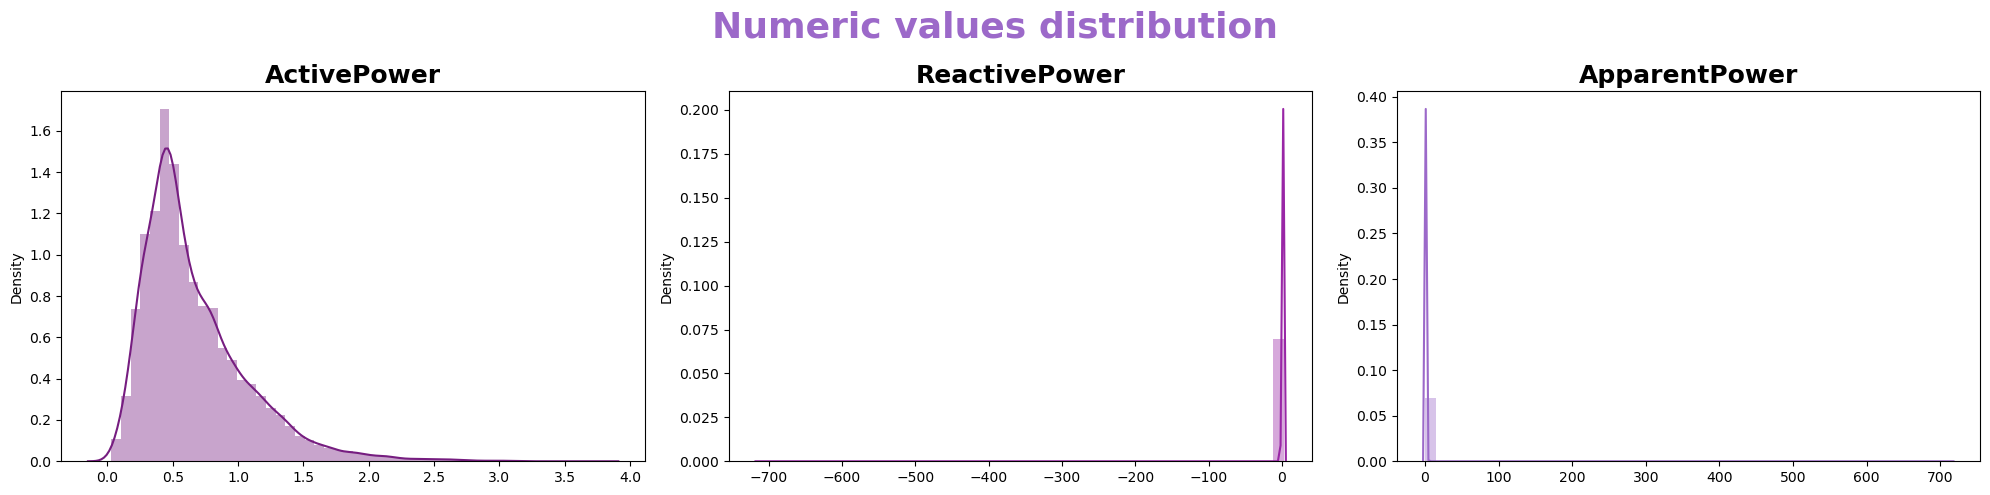

In [11]:
plot_distribution(data_arc[['ActivePower', 'ReactivePower', 'ApparentPower']])

In [12]:
# datetime
data_arc["EndHeat"] = pd.to_datetime(data_arc["EndHeat"].astype(str),format='%H:%M:%S')
data_arc["BeginHeat"] = pd.to_datetime(data_arc["BeginHeat"].astype(str),format='%H:%M:%S')

In [13]:
# calculate the total heating time in seconds
data_arc["TotalTime"] = (data_arc["EndHeat"] - data_arc["BeginHeat"]).dt.seconds
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,ApparentPower,TotalTime
0,1,1900-01-01 11:02:14,1900-01-01 11:06:02,0.976059,0.687084,1.193639,228
1,1,1900-01-01 11:07:28,1900-01-01 11:10:33,0.805607,0.520285,0.959010,185
2,1,1900-01-01 11:11:44,1900-01-01 11:14:36,0.744363,0.498805,0.896038,172
3,1,1900-01-01 11:18:14,1900-01-01 11:24:19,1.659363,1.062669,1.970470,365
4,1,1900-01-01 11:26:09,1900-01-01 11:28:37,0.692755,0.414397,0.807239,148


In [14]:
# Number of unique batches
data_arc['key'].nunique()

3214

In [15]:
data_arc_new = data_arc.groupby("key").agg(
    active_power = ('ActivePower','sum'),
    reactive_power = ('ReactivePower','sum'),
    apparent_power = ('ApparentPower', 'sum'),
    total_time = ('TotalTime', 'sum'),
    iterations = ('key', 'count')
).reset_index()


In [16]:
data_arc_new.head()

,key,active_power,reactive_power,apparent_power,total_time,iterations
0,1,4.878147,3.183241,5.826395,1098,5
1,2,3.052598,1.998112,3.649216,811,4
2,3,2.525882,1.599076,2.989534,655,5
3,4,3.209250,2.060298,3.814962,741,4
4,5,3.347173,2.252643,4.035758,869,4


/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ax=axes.flatten()[index], x=data[column], hist = True,
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



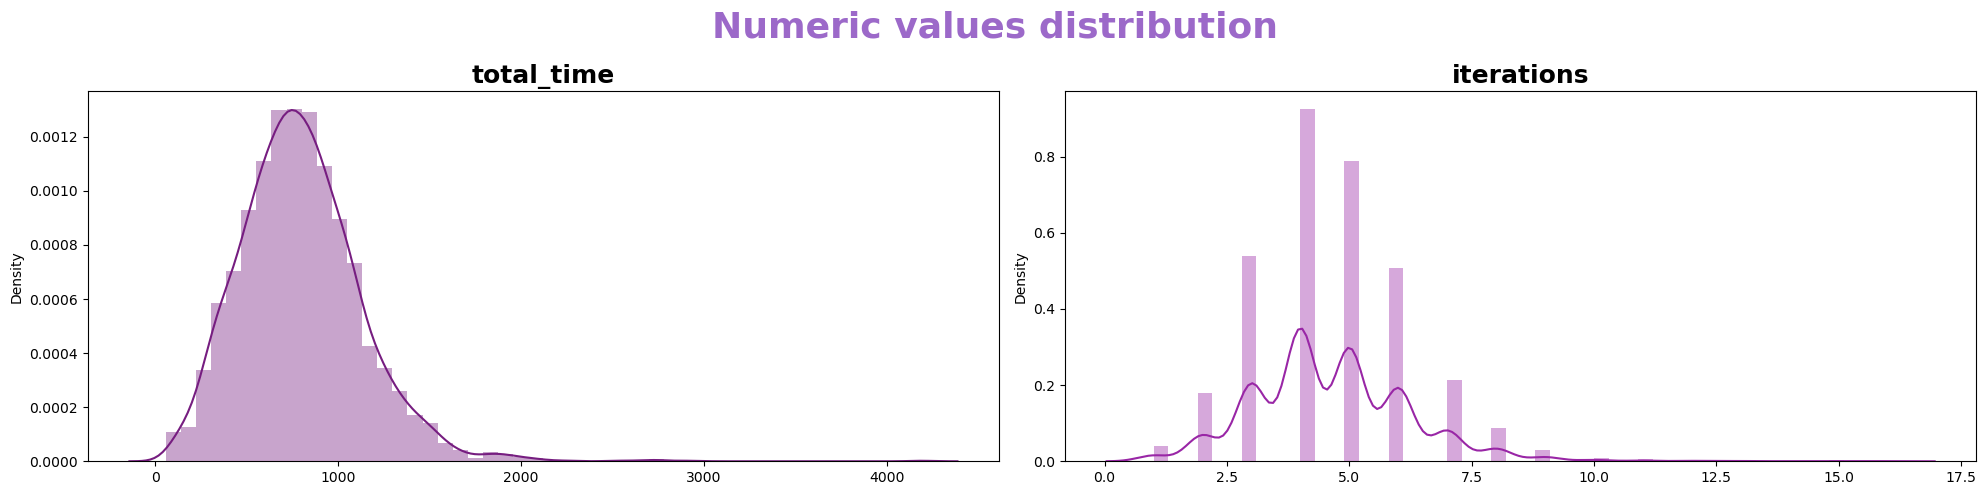

In [17]:
plot_distribution(data_arc_new[['total_time', 'iterations']])

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_arc</b></mark> with 5 columns and 14876 rows without skips or duplicates<br>
- Added an additional column <mark><b>ApparentPower</b></mark> that combines two capacity values<br>
- Converted the time data to `datetime` format and added a column for heating duration in seconds <mark><b>TotalTime</b></mark><br>
- The table contains data about 3214 unique batches. Created a new table in which we grouped the data by batch and calculated the number of heats for each. <br>
-  We looked at the distribution of numerical values: there are outliers in the ReactivePower and ApparentPower columns  <br>
</div>

### **<span style="color:#6C91BF">Table data_bulk</span>**

In [18]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_bulk''')

    data_bulk = pd.read_sql_query(query, conn)

data_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


.: Dataset Info :.
******************************
Total Rows: 3129
Total Columns: 16
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
**********

,0
Bulk 8,99.970000
Bulk 13,99.420000
Bulk 9,99.390000
Bulk 2,99.300000
Bulk 7,99.200000
Bulk 5,97.540000
Bulk 10,94.380000
Bulk 11,94.340000
Bulk 1,91.950000
Bulk 6,81.590000


In [19]:
data_bulk['key'].nunique()

3129

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Load table <mark><b>data_bulk</b></mark> which has 16 columns and 3129 rows with no duplicates.<br>
- There are many missing values in the table, this is due to the fact that different amounts of bulk materials are added to each batch <br>
</div>

### **<span style="color:#6C91BF">Table data_bulk_time</span>**

In [20]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_bulk_time''')

    data_bulk_time = pd.read_sql_query(query, conn)

data_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


.: Dataset Info :.
******************************
Total Rows: 3129
Total Columns: 16
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
*****************************

,0
Bulk 8,99.970000
Bulk 13,99.420000
Bulk 9,99.390000
Bulk 2,99.300000
Bulk 7,99.200000
Bulk 5,97.540000
Bulk 10,94.380000
Bulk 11,94.340000
Bulk 1,91.950000
Bulk 6,81.590000


In [21]:
data_bulk_time['key'].nunique()

3129

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_bulk_time</b></mark> with 16 columns and 3129 rows with no duplicates<br>
- There are a lot of omissions in the table, this is due to the fact that each batch is added different amounts of bulk materials. <br>
- This table does not contain important data for the model, we will not use it further. <br>   

</div>

### **<span style="color:#6C91BF">Table data_gas</span>**

In [22]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_gas''')

    data_gas = pd.read_sql_query(query, conn)

data_info(data_gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


.: Dataset Info :.
******************************
Total Rows: 3239
Total Columns: 2
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
******************************
.: Duplicates :.
******************************
key    0
gas    0
dtype: int64
.: Missing values :.
******************************


,0
gas,0.000000
key,0.000000


/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=data[column], hist = True,


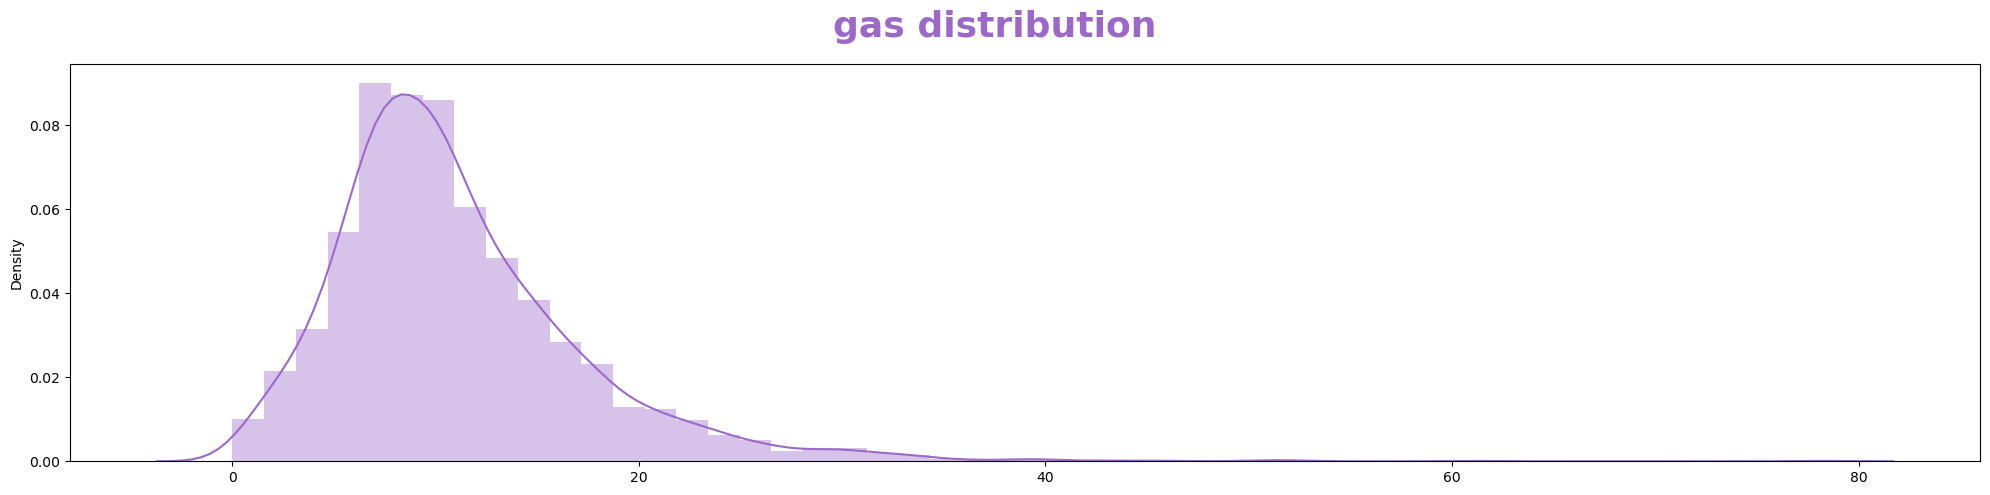

In [23]:
one_plot_distribution(data_gas, 'gas')

In [24]:
data_gas['key'].nunique()

3239

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_gas</b></mark> with 2 columns and 3239 rows with no duplicates or omissions<br>
- Data on 3239 unique batches <br>
- Looked at the distribution of gas addition values, it is close to normal, no sampling<br>
</div>

### **<span style="color:#6C91BF">Table data_temp</span>**

In [25]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_temp''')

    data_temp = pd.read_sql_query(query, conn)

data_info(data_temp)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


.: Dataset Info :.
******************************
Total Rows: 15907
Total Columns: 3
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
******************************
.: Duplicates :.
******************************
key            0
MesaureTime    0
Temperature    0
dtype: int64
.: Missing values :.
******************************


,0
Temperature,18.240000
MesaureTime,0.000000
key,0.000000


In [26]:
data_temp['key'].nunique()

3216

In [27]:
key_to_delete = data_temp[data_temp["Temperature"].isnull()]['key'].unique()

In [28]:
data_temp_new = data_temp.query("key not in @key_to_delete")

In [29]:
data_temp_new.isna().sum()

key            0
MesaureTime    0
Temperature    0
dtype: int64

In [30]:
data_temp_new = data_temp_new.groupby("key").agg(
    first_temperature = ('Temperature','first'),
    last_temperature = ('Temperature','last')
).reset_index()

In [31]:
# only leave data with a temperature greater than 1500
data_temp_new = data_temp_new[(data_temp_new['first_temperature']>=1500) & (data_temp_new['last_temperature']>=1500)]

In [32]:
data_temp_new.head()

,key,first_temperature,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [33]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 0 to 2476
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2473 non-null   int64  
 1   first_temperature  2473 non-null   float64
 2   last_temperature   2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 77.3 KB


/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ax=axes.flatten()[index], x=data[column], hist = True,
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



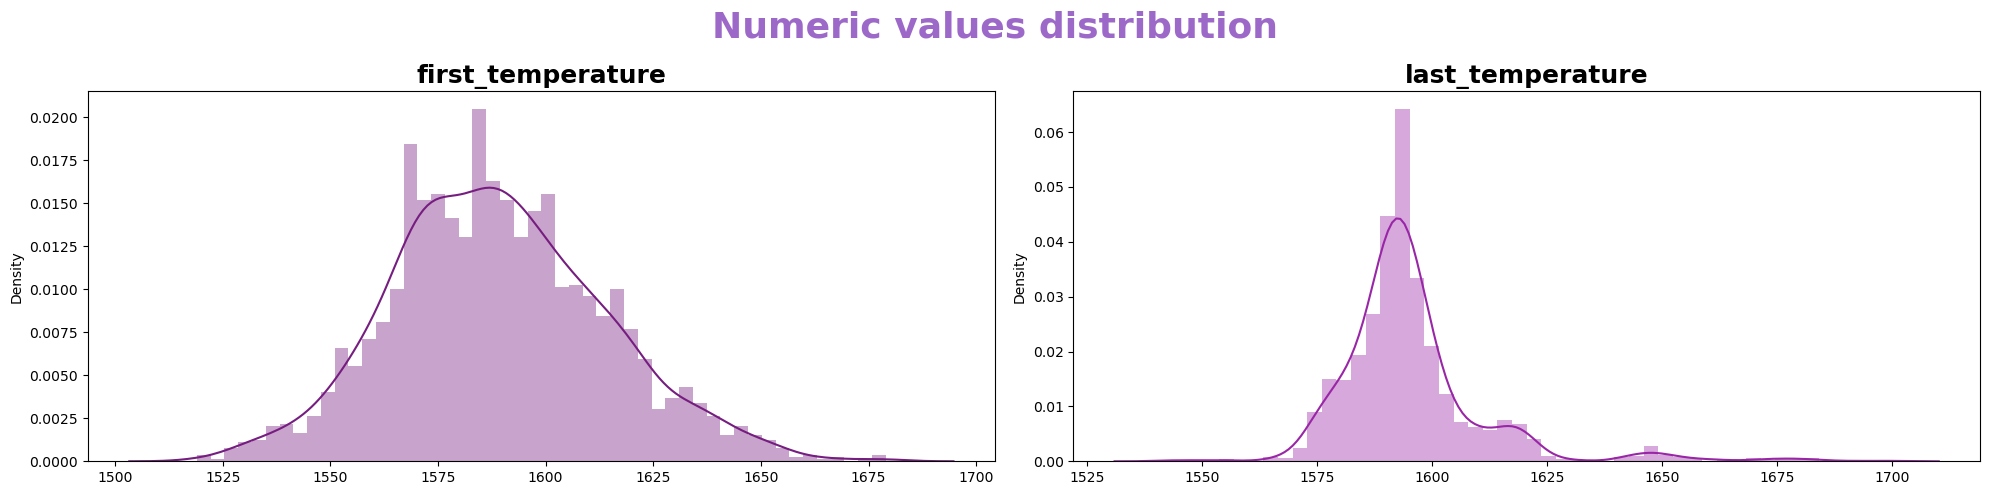

In [34]:
plot_distribution(data_temp_new[['first_temperature', 'last_temperature']])

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_temp</b></mark> which has 3 columns and 15987 rows with no duplicates.<br>
- Data on 3,216 unique batches <br>
-  There are 18.2% omissions in the Temperature column<br>
- We selected the batches with omissions and left only those batches with no omissions in the final table<br>
- Also left only values greater than 1500 C.<br>
- Grouped the data by batch and left the first and last temperatures. <mark><b>last_temperature - target </b></mark><br>
- We looked at the distribution of temperature values. For the first temperature the distribution is close to normal, for the last one it looks like a bimodal distribution<br>
</div>

### **<span style="color:#6C91BF">Table data_wire</span>**

In [35]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_wire''')

    data_wire = pd.read_sql_query(query, conn)

data_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


.: Dataset Info :.
******************************
Total Rows: 3081
Total Columns: 10
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
******************************
.: Duplicates :.
******************************
key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64
.: Missing values :.
******************

,0
Wire 5,99.970000
Wire 7,99.640000
Wire 4,99.550000
Wire 8,99.380000
Wire 9,99.060000
Wire 3,97.960000
Wire 6,97.630000
Wire 2,64.980000
Wire 1,0.840000
key,0.000000


In [36]:
data_wire['key'].nunique()

3081

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_wire</b></mark> with 10 columns and 3081 rows with no duplicates<br>
- There are many omissions in the table, this is due to the fact that different amounts of wire are added to each batch. Mostly samples 1 and 2 are used. At least one wire was added to each batch of metal. <br>
</div>

### **<span style="color:#6C91BF">Table data_wire_time</span>**

In [37]:
with engine.begin() as conn:
    query = text('''SELECT *
    FROM steel.data_wire_time''')

    data_wire_time = pd.read_sql_query(query, conn)

data_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


.: Dataset Info :.
******************************
Total Rows: 3081
Total Columns: 10
******************************
.: Dataset Details :.
******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
******************************
.: Duplicates :.
******************************
key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64
.: Missing values :.
******************************


,0
Wire 5,99.970000
Wire 7,99.640000
Wire 4,99.550000
Wire 8,99.380000
Wire 9,99.060000
Wire 3,97.960000
Wire 6,97.630000
Wire 2,64.980000
Wire 1,0.840000
key,0.000000


In [38]:
data_wire_time['key'].nunique()

3081

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Loaded a table <mark><b>data_wire</b></mark> with 10 columns and 3081 rows with no duplicates<br>
- This table does not contain important data for the model, we will not use it further
</div>

## <b><span style='color:#761D80'>4 |</span><span style='color:#761D80'> Data pre-processing </span></b>

Merge all tables into one table by "key"

In [39]:
data = (data_arc_new.merge(data_temp_new, how="inner", on="key")\
        .merge(data_bulk, how="inner", on="key")\
        .merge(data_wire, how="inner", on="key")\
        .merge(data_gas, how="inner", on="key"))


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2325 non-null   int64  
 1   active_power       2325 non-null   float64
 2   reactive_power     2325 non-null   float64
 3   apparent_power     2325 non-null   float64
 4   total_time         2325 non-null   int64  
 5   iterations         2325 non-null   int64  
 6   first_temperature  2325 non-null   float64
 7   last_temperature   2325 non-null   float64
 8   Bulk 1             199 non-null    float64
 9   Bulk 2             13 non-null     float64
 10  Bulk 3             958 non-null    float64
 11  Bulk 4             811 non-null    float64
 12  Bulk 5             53 non-null     float64
 13  Bulk 6             438 non-null    float64
 14  Bulk 7             13 non-null     float64
 15  Bulk 8             1 non-null      float64
 16  Bulk 9             13 no

In [41]:
data.tail()

,key,active_power,reactive_power,apparent_power,total_time,iterations,first_temperature,last_temperature,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
2320,2495,3.210690,2.360777,3.986869,723,4,1570.0,1591.0,NaN,NaN,...,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.125735
2321,2496,4.203064,2.810185,5.057033,940,6,1554.0,1591.0,NaN,NaN,...,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.412616
2322,2497,2.212379,1.851269,2.885017,569,3,1571.0,1589.0,NaN,NaN,...,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.271699
2323,2498,3.408725,2.355428,4.143749,750,5,1591.0,1594.0,NaN,NaN,...,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.953657
2324,2499,4.098431,2.777865,4.953010,883,4,1569.0,1603.0,NaN,NaN,...,110.160958,50.00528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.336151


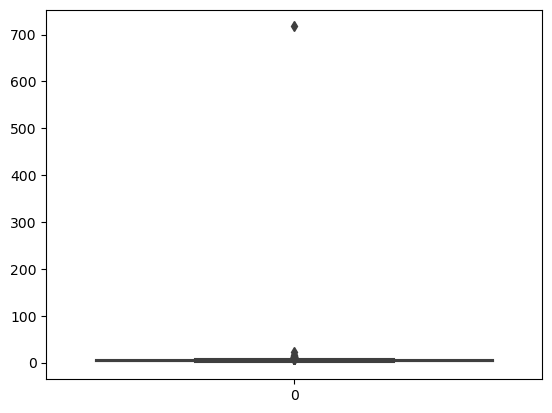

In [42]:
# outliars in apparent_power
sns.boxplot(data['apparent_power']);


Check this outlier and remove it

In [43]:
data[data['apparent_power']>700]

,key,active_power,reactive_power,apparent_power,total_time,iterations,first_temperature,last_temperature,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
1977,2116,1.848681,-714.591636,717.137585,433,4,1579.0,1578.0,NaN,NaN,...,75.216965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.582547


In [44]:
data = data.drop(2097)

In [45]:
# Fill missing values with 0
data = data.fillna(0)

In [46]:
data.describe()

,key,active_power,reactive_power,apparent_power,total_time,iterations,first_temperature,last_temperature,Bulk 1,Bulk 2,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,...,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.083046,3.154043,2.044228,4.251461,808.012478,4.697074,1587.363597,1593.366609,3.435026,1.425559,...,102.416231,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,11.377005
std,714.953345,1.425581,14.911214,14.900723,340.900910,1.605889,23.628107,11.211957,12.424463,19.102530,...,43.544198,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,6.396326
min,1.000000,0.186226,-714.591636,0.257637,57.000000,1.000000,1519.000000,1541.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008399
25%,628.750000,2.173710,1.627043,2.739184,581.000000,4.000000,1571.000000,1587.000000,0.000000,0.000000,...,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,7.282534
50%,1254.500000,3.028796,2.235148,3.774782,778.000000,5.000000,1587.000000,1593.000000,0.000000,0.000000,...,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10.100687
75%,1867.250000,3.921157,2.916348,4.901178,993.000000,6.000000,1603.000000,1598.000000,0.000000,0.000000,...,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,14.216939
max,2499.000000,17.496497,12.587990,717.137585,4189.000000,16.000000,1660.000000,1653.000000,185.000000,325.000000,...,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,77.995040


interval columns not set, guessing: ['key', 'active_power', 'reactive_power', 'apparent_power', 'total_time', 'iterations', 'first_temperature', 'last_temperature', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas']


/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable Wire 5 for analysis 1. Dropping this column
  warnings.warn(


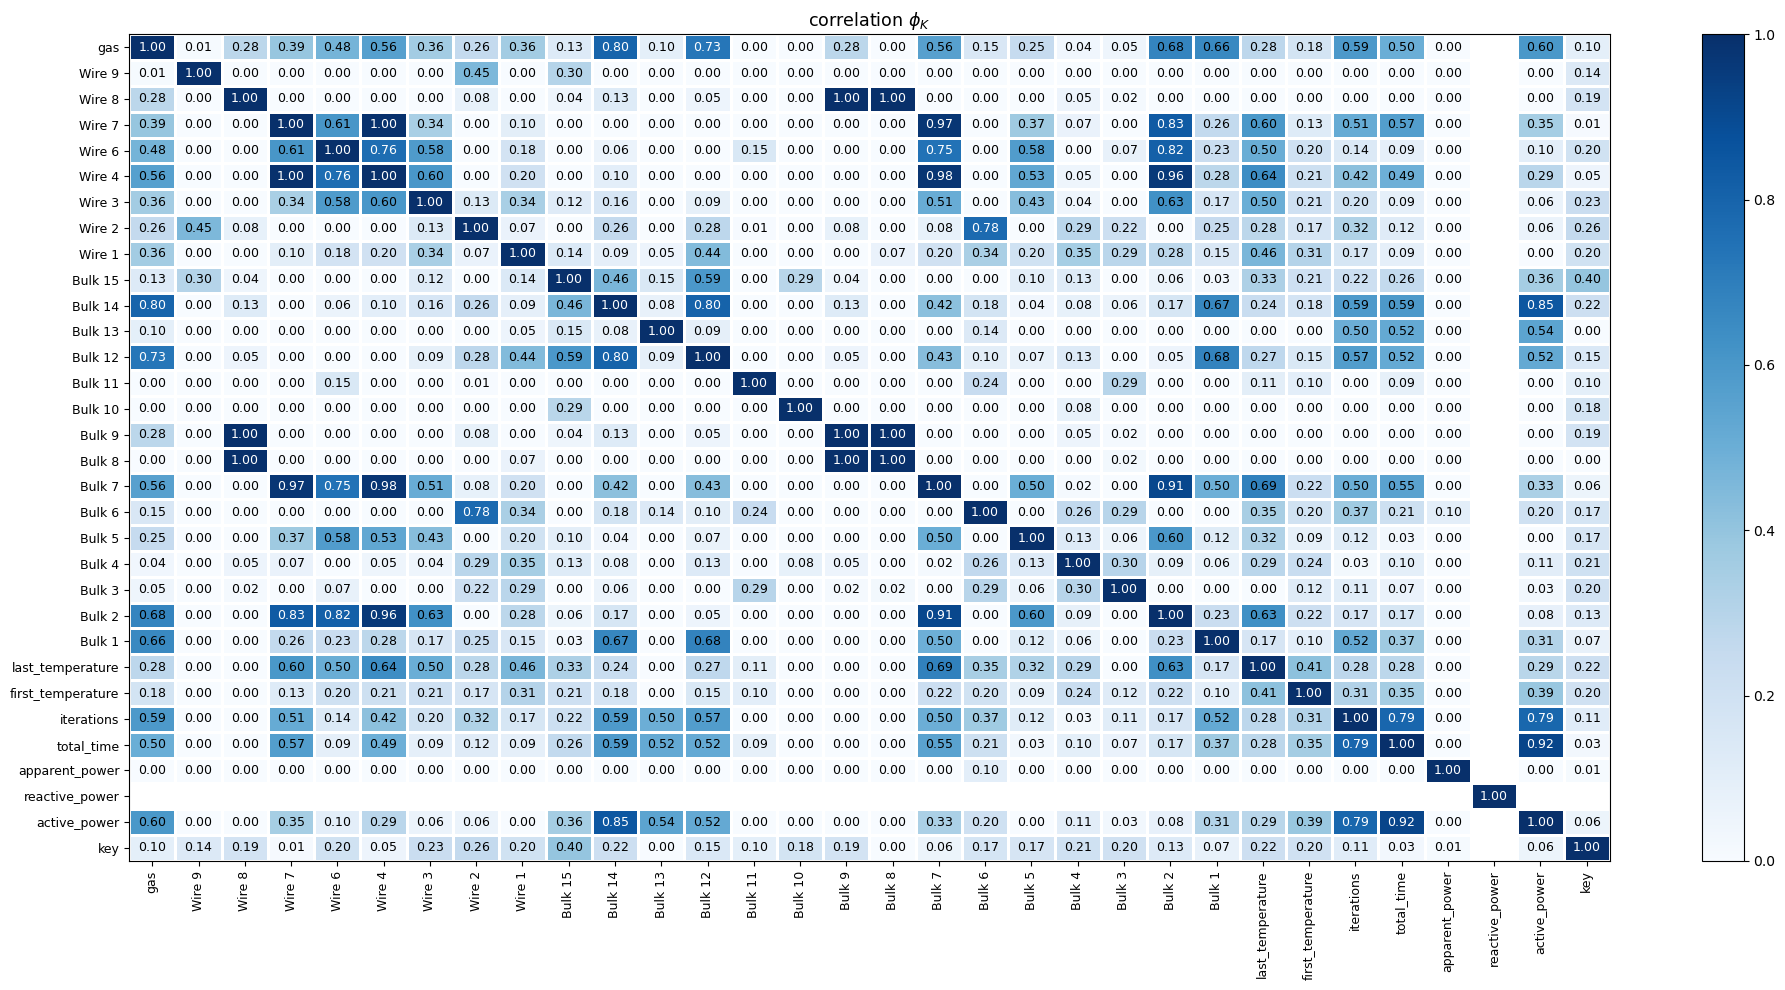

In [47]:
# Correlation matrix
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9,
                        figsize=(20, 10))
plt.tight_layout()

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">

From phik_matrix we can see that there are strong dependencies between apparent_power and reactive_power and active_power, and bulk_9 and wire_8. Since they are essentially duplicates of each other, we leave only apparent_power and bulk_9


In [48]:
features = ['apparent_power', 'total_time',
            'iterations', 'first_temperature', 'gas', 'Bulk 1',
            'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
            'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 8', 'Wire 9']
target = ['last_temperature']


In [49]:
features_data = data[features]
target_data = data[target]

In [50]:
RANDOM_STATE=300422

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features_data, 
                                                    target_data, 
                                                    test_size=0.25, 
                                                    shuffle=False, 
                                                    random_state=RANDOM_STATE)


In [52]:
print(clr.S + 'Training sample size: ' + clr.E + f'{X_train.shape}')
print(clr.S + 'Testing sample size:' + clr.E + f'{X_test.shape}')


Размер обучающей выборки: (1743, 27)
Размер тестовой выборки: (581, 27)


In [53]:
scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ax=axes.flatten()[index], x=data[column], hist = True,
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/2640802095.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



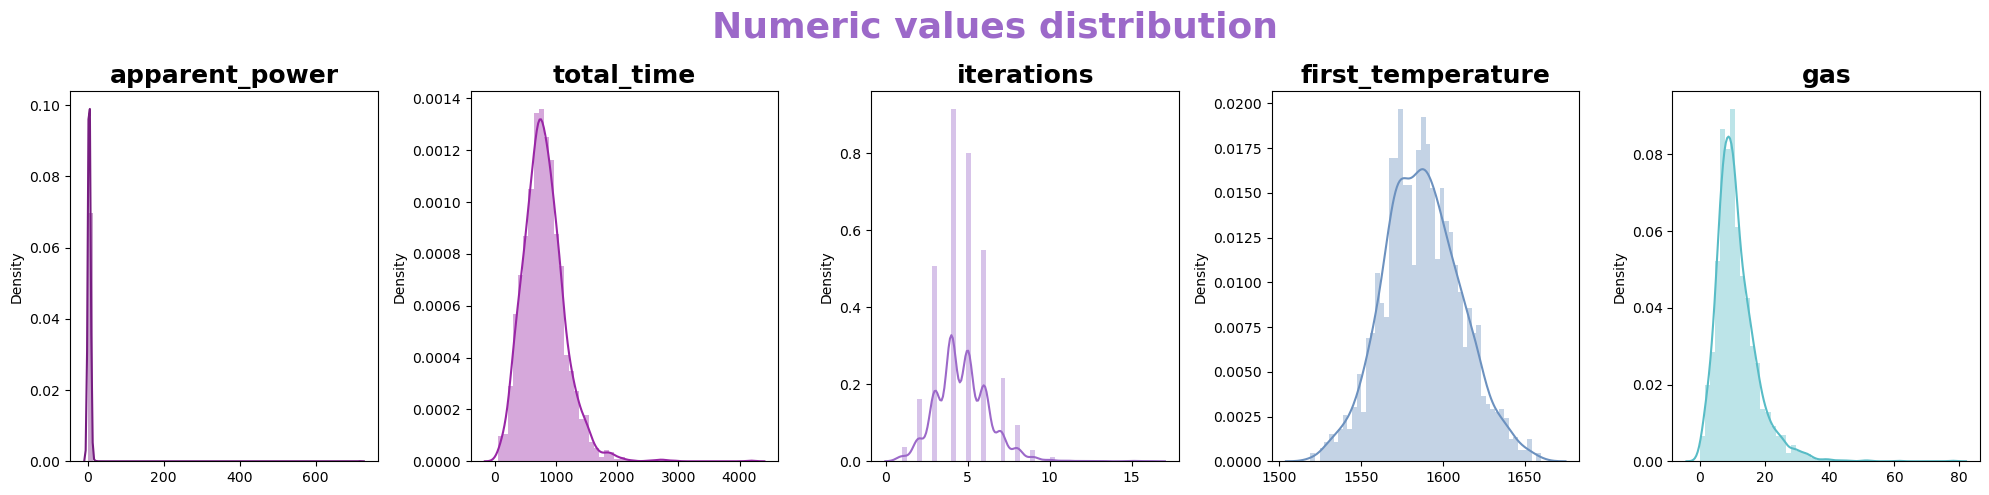

In [54]:
plot_distribution(features_data[features_data.columns[0:5]])


## <b><span style='color:#761D80'>5 |</span><span style='color:#761D80'> Model training </span></b>

In [55]:
kf = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)

In [135]:
def cv(model, X, y):
    scores = cross_validate(model, X, y, cv=kf,
                            scoring=('neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'),
                             return_train_score=True)
    rmse = scores['test_neg_root_mean_squared_error']
    mae = scores['test_neg_mean_absolute_error']
    r2 = scores['test_r2']
    return rmse, mae, r2

### **<span style="color:#6C91BF">Models</span>**

In [57]:
dummy = DummyRegressor(strategy ="mean")
ridge = Ridge()
rf = RandomForestRegressor(random_state=RANDOM_STATE)
lightgbm = LGBMRegressor(random_state=RANDOM_STATE)
xgboost = XGBRegressor(random_state=RANDOM_STATE)

In [58]:
scores_dict = {}

In [59]:
models = {
    'dummy': dummy,
    'ridge': ridge,
    'rf': rf,
    'lgbm': lightgbm,
    'xgb': xgboost
}


In [137]:
print(">>>> Training started <<<<")
for key in models:
    model = models[key]
    rmse, mae, r2 = cv(model, X_train, y_train)
    scores_dict[key] = - 1 * mae.mean()
    print(clr.S +f"{key} - MAE:" +clr.E+  " %0.3f" %(-1 * mae.mean()))
    print(clr.S +f"{key} - RMSE:" +clr.E+  " %0.3f" %(-1 * rmse.mean()))
    print(clr.S +f"{key} - R2:" +clr.E+  " %0.3f" %(r2.mean()))
    model.fit(X_train, y_train)
    # Save model for prediction
    models[key] = model

>>>> Training started <<<<
dummy - MAE: 8.060
dummy - RMSE: 11.011
dummy - R2: -0.002
ridge - MAE: 6.127
ridge - RMSE: 8.330
ridge - R2: 0.427


/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-

rf - MAE: 6.242
rf - RMSE: 8.354
rf - R2: 0.423


/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/843367046.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed w

lgbm - MAE: 6.134
lgbm - RMSE: 8.312
lgbm - R2: 0.428


/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


xgb - MAE: 6.477
xgb - RMSE: 8.707
xgb - R2: 0.372


<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- We selected 4 ML models for training, evaluated the quality of the models on cross-validation using the MAE metric <br> 
- DummyRegressor with MAE metric was trained as the baseline model: 10.738 <br>  
- R2 is usually used to determine the quality of a linear regression model, which shows how much the pre-sold and real data match. For the analysed models it is below 50% <br> 
    
</div>

### **<span style="color:#6C91BF">Hyperparameters tunning: Optuna</span>**

In [61]:
models_optuna = []

In [62]:
# RandomForest
def objective(trial):

    r_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson']),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'bootstrap': False,
        'oob_score': False,
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'random_state': RANDOM_STATE
    }

    model = RandomForestRegressor(**r_params)
    return (-1 * cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')).mean()


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

rf_optuna = RandomForestRegressor(**study.best_params)
rf_optuna.fit(X_train, y_train)
models_optuna.append(rf_optuna)
scores_dict['rf_optuna'] = study.best_value

print(clr.S + 'MAE score:'+ clr.E + '{}'.format(study.best_value))
print(clr.S +'Best hyperparameters:'+ clr.E + '{}'.format(study.best_params))


[I 2023-05-04 15:06:37,077] A new study created in memory with name: no-name-96ddf38a-f67d-4f98-9820-de18d31c71bd
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using r

MAE score:6.328984041127358
Best hyperparameters:{'n_estimators': 140, 'min_samples_split': 6, 'min_samples_leaf': 2, 'criterion': 'squared_error', 'max_features': 'sqrt', 'warm_start': False, 'ccp_alpha': 0.1055436840023712, 'max_depth': 44}


In [63]:
# LightGBM
def objective(trial):

    r_params = {
        'random_state': RANDOM_STATE,
        'n_estimators': 2000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }

    model = LGBMRegressor(**r_params)
    return (-1 * cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', error_score='raise')).mean()


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

lgbm_optuna = LGBMRegressor(**study.best_params)
lgbm_optuna.fit(X_train, y_train)
models_optuna.append(lgbm_optuna)
scores_dict['lgbm_optuna'] = study.best_value

print(clr.S + 'MAE score:'+ clr.E + '{}'.format(study.best_value))
print(clr.S +'Best hyperparameters:'+ clr.E + '{}'.format(study.best_params))

[I 2023-05-04 15:14:34,548] A new study created in memory with name: no-name-9d85f2bd-f22c-4da6-bf28-84467e14f7a6
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/664240696.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
/var/folders/bq/w9mfn2pd17s1yh2fbrn4ghqr0000gn/T/ipykernel_64254/664240696.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
/Users/user/miniforge3/envs/boost_new/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed w

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
MAE score:6.123854481274655
Best hyperparameters:{'reg_alpha': 5.7698206901705875, 'reg_lambda': 0.11131774645831, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 20, 'num_leaves': 669, 'min_child_samples': 45, 'min_data_per_groups': 10}


In [64]:
# XGBRegressor
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }

    model = XGBRegressor(**param)
    return (-1 * cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error', error_score='raise')).mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

xgb_optuna = XGBRegressor(**study.best_params)
xgb_optuna.fit(X_train, y_train)
models_optuna.append(xgb_optuna)
scores_dict['xgb_optuna'] = study.best_value

print(clr.S + 'MAE score:'+ clr.E + '{}'.format(study.best_value))
print(clr.S +'Best hyperparameters:'+ clr.E + '{}'.format(study.best_params))

[I 2023-05-04 15:43:56,495] A new study created in memory with name: no-name-c521ffce-e473-46cf-a56b-55bec0c97464
[I 2023-05-04 15:44:07,921] Trial 0 finished with value: 7.7953388850459575 and parameters: {'max_depth': 4, 'learning_rate': 0.8581311692009824, 'n_estimators': 675, 'min_child_weight': 9, 'gamma': 0.9146498480893572, 'subsample': 0.9419681761823195, 'colsample_bytree': 0.27770465825220836, 'reg_alpha': 0.16420100230017654, 'reg_lambda': 0.6813048695738897, 'random_state': 219}. Best is trial 0 with value: 7.7953388850459575.
[I 2023-05-04 15:44:24,199] Trial 1 finished with value: 6.824008508481296 and parameters: {'max_depth': 3, 'learning_rate': 0.2548369934383893, 'n_estimators': 890, 'min_child_weight': 3, 'gamma': 0.16591508591651508, 'subsample': 0.5870377675870869, 'colsample_bytree': 0.7567661742672496, 'reg_alpha': 0.6252498020579692, 'reg_lambda': 0.4057692020177714, 'random_state': 701}. Best is trial 1 with value: 6.824008508481296.
[I 2023-05-04 15:44:56,754]

MAE score:5.9767880673473375
Best hyperparameters:{'max_depth': 10, 'learning_rate': 0.012430164722587126, 'n_estimators': 677, 'min_child_weight': 8, 'gamma': 0.011129253128858457, 'subsample': 0.7233575246364627, 'colsample_bytree': 0.7627572856286899, 'reg_alpha': 0.6018991194059053, 'reg_lambda': 0.8284052059661093, 'random_state': 959}


<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- For Randomforest, LGBM and XGB models, we performed a hyperparameter search using Optuna  <br>
- The XGBRegressor model with MAE=6.18 showed the best quality on validation <br>

</div>

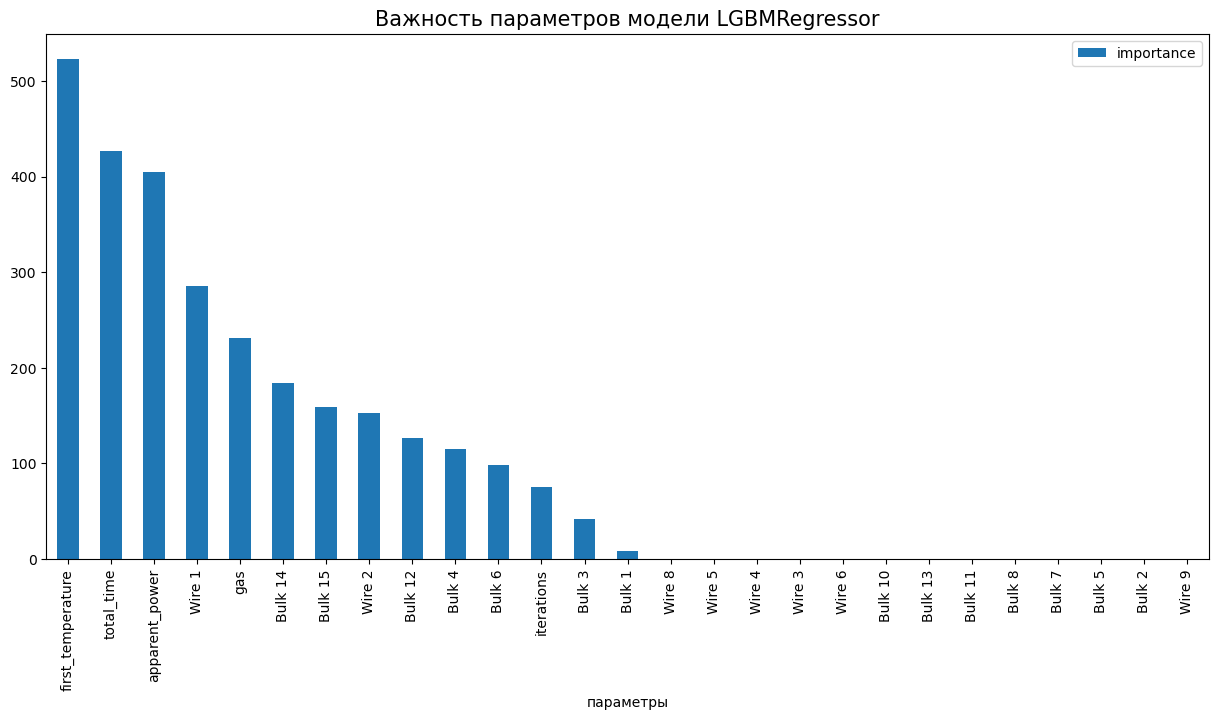

In [65]:
importance_lgbm = (pd.DataFrame({'feature': features, 'importance': lgbm_optuna.feature_importances_}).sort_values(by='importance', ascending=False).reset_index())

plt.figure(figsize=(15, 15))
plt.subplot(211)           
importance_lgbm.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('Parameters')
plt.title('Feature importance for LGBMRegressor', fontsize=15)
plt.show()


<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Most important features: first_temperature, apparent_power и wire_1  <br>

</div>

### **<span style="color:#6C91BF">Neural net</span>**

In [61]:
X_train_net, X_valid_net, y_train_net, y_valid_net = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for d, n in zip([X_train_net, y_train_net, X_valid_net, y_valid_net], ['X_train', 'y_train', 'X_valid', 'y_valid']):
    print(n+' shape:', d.shape)

X_train shape: (1481, 27)
y_train shape: (1481, 1)
X_valid shape: (371, 27)
y_valid shape: (371, 1)


In [62]:
X_train_tensor = torch.FloatTensor(X_train_net)
X_valid_tensor = torch.FloatTensor(X_valid_net)
y_train_tensor = torch.FloatTensor((y_train_net['last_temperature']).to_numpy()).reshape(y_train.shape[0], 1)
y_valid_tensor = torch.FloatTensor((y_valid_net['last_temperature']).to_numpy()).reshape(y_valid.shape[0], 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor((y_test['last_temperature']).to_numpy()).reshape(y_test.shape[0], 1)

In [63]:
print(X_train_tensor.dtype)
print(X_train_tensor.shape)
print(y_train_tensor.dtype)
print(y_train_tensor.shape)
print(X_test_tensor.shape)

torch.float32
torch.Size([1481, 27])
torch.float32
torch.Size([1481, 1])
torch.Size([618, 27])


In [68]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: mps


In [65]:
batch_size = 512

dataset = {
    'train': torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
    'valid': torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor),
    'test': torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    
}

dataloaders = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=batch_size, shuffle=True
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=512, shuffle=False
    ),
    'test': torch.utils.data.DataLoader(
        dataset=dataset['test'], batch_size=256, shuffle=False
    )
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid', 'test']}

In [69]:
n_in_neurons, n_out_neurons = X_train_tensor.shape[1], 1

mae = MeanAbsoluteError().to(device)
rmse = MeanSquaredError(squared = False).to(device)

In [70]:
class Net(nn.Module):

    def __init__(self, input_dim=n_in_neurons, num_layers=0, hidden_dim=16, output_dim=n_out_neurons, p=0.0, div=0):
        super().__init__()
        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i),
                                   torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
            if div!=0 and div!=1:
                hidden_dim = hidden_dim // 2

        self.layers.add_module('classifier', torch.nn.Linear(prev_size, output_dim))


    def forward(self, x):
        return self.layers(x)

In [68]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = {"epochs": np.arange(num_epochs)+1, "train": {"score": [], "loss": []}, "valid": {"score": [], "loss": []}}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        for phase in ['train', 'valid']:

            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':

                model.train(True)  
            else:
                model.eval()

            for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):

                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == "train":
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    # backward pass
                    loss.backward()
                    optimizer.step()

                # forward pass
                if phase == " valid":
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)


                # statistics
                pred = model(inputs)
                running_loss += loss.item()
                running_corrects += mae(pred, labels).cpu()



            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]

            history[phase]["score"].append(epoch_acc.item())
            history[phase]["loss"].append(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
            ))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history

In [90]:
def make_graph(history, model_name, loss_name):
    fig, ax = plt.subplots(1, 2, figsize = (14, 7))
    x = history["epochs"]
    loss_train = history["train"]["loss"]
    loss_val = history["valid"]["loss"]
    score_train = history["train"]["score"]
    score_val = history["valid"]["score"]
    ax[0].plot(x, loss_train, label = "train", color = "green")
    ax[0].plot(x, loss_val, label = "valid", color = "orange")
    ax[0].legend(fontsize = 14)
    ax[0].grid(linestyle = "--")
    ax[0].tick_params(labelsize = 14)
    ax[0].set_xlabel("epoch", fontsize = 14)
    ax[0].set_ylabel("loss", fontsize = 14)
    ax[0].set_title("Loss vs epoch", fontsize = 16)
    ax[0].set_xlim(left = 0, right = x.max())
    ax[0].set_ylim(bottom = 0)
    ax[1].plot(x, score_train, label = "train", color = "green")
    ax[1].plot(x, score_val, label = "valid", color = "orange")
    ax[1].legend(fontsize = 14)
    ax[1].grid(linestyle = "--")
    ax[1].tick_params(labelsize = 14)
    ax[1].set_xlabel("epoch", fontsize = 14)
    ax[1].set_ylabel("score", fontsize = 14)
    ax[1].set_title("Score vs epoch", fontsize = 16)
    ax[1].set_xlim(left = 0, right = x.max())
    ax[1].set_ylim(bottom = 0)
    plt.suptitle(f"Model = {model_name}, loss = {loss_name}", fontsize = 18, y=1.0)
    plt.tight_layout()
    plt.show()


In [70]:
model_net = Net(input_dim=n_in_neurons, num_layers=3, hidden_dim=512, output_dim=n_out_neurons, p=0.7, div=2).to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model_net.parameters(), lr=1e-4)

model, history = train_model(model_net, criterion=loss, optimizer=optimizer, num_epochs=1300)

valid iter::   0%|                                        | 0/1 [00:00<?, ?it/s]
valid Loss: 64158250273.8113 Acc: 4.3015:   0%| | 1/1300 [00:00<11:42,  1.85it/s
train iter::   0%|                                        | 0/3 [00:00<?, ?it/s]
train Loss: 9467565966.3687 Acc: 92.5002:   0%| | 1/1300 [00:00<11:42,  1.85it/s
valid iter::   0%|                                        | 0/1 [00:00<?, ?it/s]
valid Loss: 31639082163.4070 Acc: 4.3014:   0%| | 1/1300 [00:00<11:42,  1.85it/s
train iter::   0%|                                        | 0/3 [00:00<?, ?it/s]
train Loss: 12720226184.4456 Acc: 163.8381:   0%| | 1/1300 [00:00<11:42,  1.85it
valid iter::   0%|                                        | 0/1 [00:00<?, ?it/s]
valid Loss: 34533064306.5445 Acc: 4.3014:   0%| | 3/1300 [00:00<04:30,  4.79it/s
train iter::   0%|                                        | 0/3 [00:00<?, ?it/s]
train Loss: 7942938291.0574 Acc: 124.0669:   0%| | 3/1300 [00:00<04:30,  4.79it/
train iter::   0%|          

Training complete in 2m 36s
Best valid Acc: 4.301463


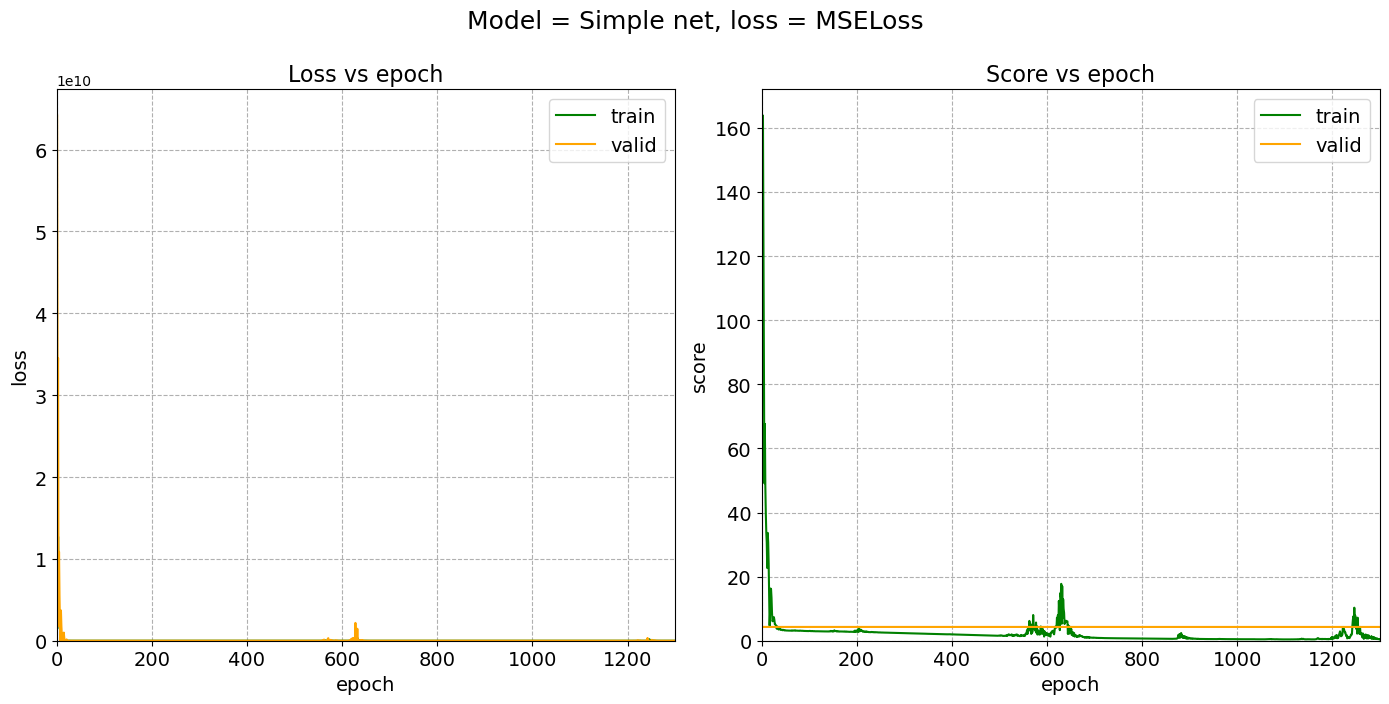

In [71]:
make_graph(history, 'Simple net', 'MSELoss')

**Cross-validation**

In [66]:
X_train_cv = torch.FloatTensor(X_train)
y_train_cv = torch.FloatTensor((y_train['last_temperature']).to_numpy()).reshape(y_train.shape[0], 1)

X_test_cv = torch.FloatTensor(X_test)
y_test_cv = torch.FloatTensor((y_test['last_temperature']).to_numpy()).reshape(y_test.shape[0], 1)

In [67]:
dataset = {
    'train': torch.utils.data.TensorDataset(X_train_cv, y_train_cv),
    'test': torch.utils.data.TensorDataset(X_test_cv, y_test_cv)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train','test']}

In [87]:
batch_size = 512
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)

In [130]:
def train_model_cv(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = {"epochs": np.arange(num_epochs)+1, "train": {"score": [], "loss": []}, "valid": {"score": [], "loss": []}}
    acc_list = []
    
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(dataset_size['train']))):
        fold_acc = 0
        print('Fold {}'.format(fold + 1))

        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)

        dataloaders = {
                    'train': torch.utils.data.DataLoader(
                        dataset['train'], batch_size=batch_size, sampler=train_sampler),
                    'valid': torch.utils.data.DataLoader(
                        dataset['train'], batch_size=batch_size, sampler=test_sampler
                    ),
                }

        pbar = trange(num_epochs, desc="Epoch:")
        for epoch in pbar:

            for phase in ['train', 'valid']:

                running_loss = 0.0
                running_corrects = 0

                if phase == 'train':
                    model.train(True)  
                else:
                    model.eval()

                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    if phase == "train":
                        optimizer.zero_grad()
                        outp = model(inputs)
                        loss = criterion(outp, labels)
                        # backward pass
                        loss.backward()
                        optimizer.step()

                    # forward pass
                    if phase == " valid":
                        with torch.no_grad():
                            outp = model(inputs)
                            loss = criterion(outp, labels)

                    pred = model(inputs)
                    running_loss += loss.item()
                    running_corrects += mae(pred, labels).cpu()


                if phase == 'train':
                    epoch_loss = running_loss / len(train_sampler)
                    epoch_acc = running_corrects / len(train_sampler)
                else:
                    epoch_loss = running_loss / len(test_sampler)
                    epoch_acc = running_corrects / len(test_sampler)

                history[phase]["score"].append(epoch_acc.item())
                history[phase]["loss"].append(epoch_loss)
                fold_acc = epoch_acc.item()
                
                pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc
                ))

                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
               
        acc_list.append(fold_acc)
        
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))
    
    print('Average CV Accuracy: {}'.format(np.mean(acc_list)))

    model.load_state_dict(best_model_wts)
    
    return model, history, acc_list

In [131]:
model_cv = Net(input_dim=n_in_neurons, num_layers=3, hidden_dim=512, output_dim=n_out_neurons, p=0.7, div=2).to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model_cv.parameters(), lr=1e-4)

model, history, l = train_model_cv(model_cv, criterion=loss, optimizer=optimizer, num_epochs=20)

Fold 1


valid Loss: 27612.1347 Acc: 4.5651: 100%|███████| 20/20 [00:02<00:00,  8.26it/s]


Fold 2


valid Loss: 22874.3138 Acc: 4.5664: 100%|███████| 20/20 [00:02<00:00,  8.99it/s]


Fold 3


valid Loss: 215177.0086 Acc: 4.5666: 100%|██████| 20/20 [00:02<00:00,  8.64it/s]


Fold 4


valid Loss: 10010.2981 Acc: 4.5802: 100%|███████| 20/20 [00:02<00:00,  8.90it/s]


Fold 5


valid Loss: 177674.5632 Acc: 4.5816: 100%|██████| 20/20 [00:02<00:00,  8.76it/s]

Training complete in 0m 11s
Best valid Acc: 4.581691
Average CV Accuracy: 4.5719828605651855


In [139]:
avg_train_acc = np.mean(history['train']['score'])
avg_test_acc = np.mean(history['valid']['score'])
avg_train_loss = np.mean(history['train']['loss'])
avg_test_loss = np.mean(history['valid']['loss'])


print(clr.S + 'Performance of {} fold cross validation'.format(k) + clr.E)
print("Average Training Loss: {:.4f} \nAverage Test Loss: {:.4f} \nAverage Training Acc: {:.3f} \nAverage Test Acc: {:.3f}".format(avg_train_loss,avg_test_loss,avg_train_acc,avg_test_acc))  


Performance of 5 fold cross validation
Average Training Loss: 237713438.2582 
Average Test Loss: 375592625.5108 
Average Training Acc: 14.265 
Average Test Acc: 4.572


In [133]:
scores_dict['NeuralNetwork'] = avg_test_acc

### **<span style="color:#6C91BF">Best model</span>**

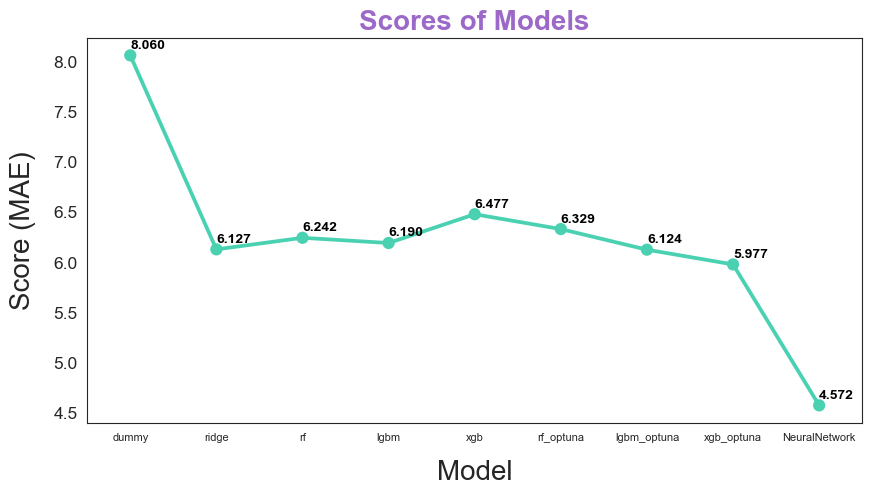

In [134]:
sns.set_style("white")
fig = plt.figure(figsize=(10, 5))

ax = sns.pointplot(x=list(scores_dict.keys()), y=[score for score in scores_dict.values()], 
                   markers=['o'], linestyles=['-'], color=my_colors[5])
for i, score in enumerate(scores_dict.values()):
    ax.text(i, score + 0.07, '{:.3f}'.format(score), horizontalalignment='left', 
            size=10, color='black', weight='semibold')

plt.ylabel('Score (MAE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', fontweight='heavy', fontsize=20,
                 fontfamily='sans-serif', color=my_colors[2])

plt.show()

<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- The best result was shown by the neural network<br>
- In second place XGBRegressor with selected hyperparameters <br>

</div>

## <b><span style='color:#761D80'>6 |</span><span style='color:#761D80'> Testing </span></b>

**Check the second best result of XGBRegressor with selected hyperparameters on the test sample**

In [118]:
params = {'max_depth': 5, 
                      'learning_rate': 0.04293015018598237, 
                      'n_estimators': 271, 
                      'min_child_weight': 4, 
                      'gamma': 0.7856068118186643, 
                      'subsample': 0.8269712547912881, 
                      'colsample_bytree': 0.6567447712077602, 
                      'reg_alpha': 0.8639593840391935, 
                      'reg_lambda': 0.6369296478204771, 
                      'random_state': 229}
model_xgb = XGBRegressor(**params).fit(X_train, y_train)
pred = model_xgb.predict(X_test)
print(clr.S+'test MAE:'+clr.E, mean_absolute_error(y_test, pred))
print(clr.S+'test RMSE:'+clr.E, mean_squared_error(y_test, pred, squared=False))

test MAE: 6.4275913
test RMSE: 9.468121


In [119]:
test_preds = pd.DataFrame(pred, columns=['temperature'])
test_target = pd.DataFrame(y_test, columns=['temperature'])

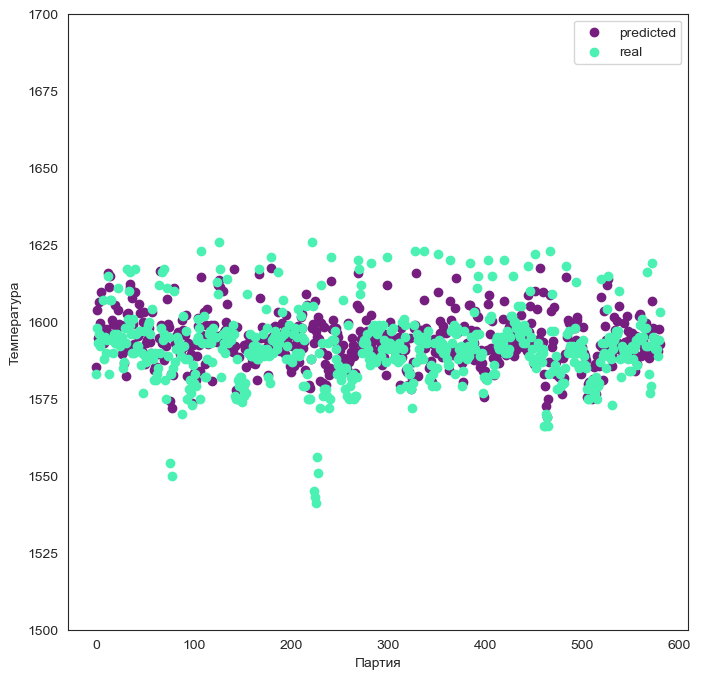

In [120]:
fig, ax = plt.subplots(figsize=[8,8])
plt.scatter(x=test_preds.index, y=test_preds['temperature'], color=my_colors[0] , label='predicted')
plt.scatter(x=test_target.index, y=test_target['temperature'], color=my_colors[-1], label='real')
plt.xlabel('Партия')
plt.ylabel('Температура')
plt.ylim([1500, 1700])
ax.legend()
plt.show()

On the test sample, the best model showed a MAE result: 6.6528034

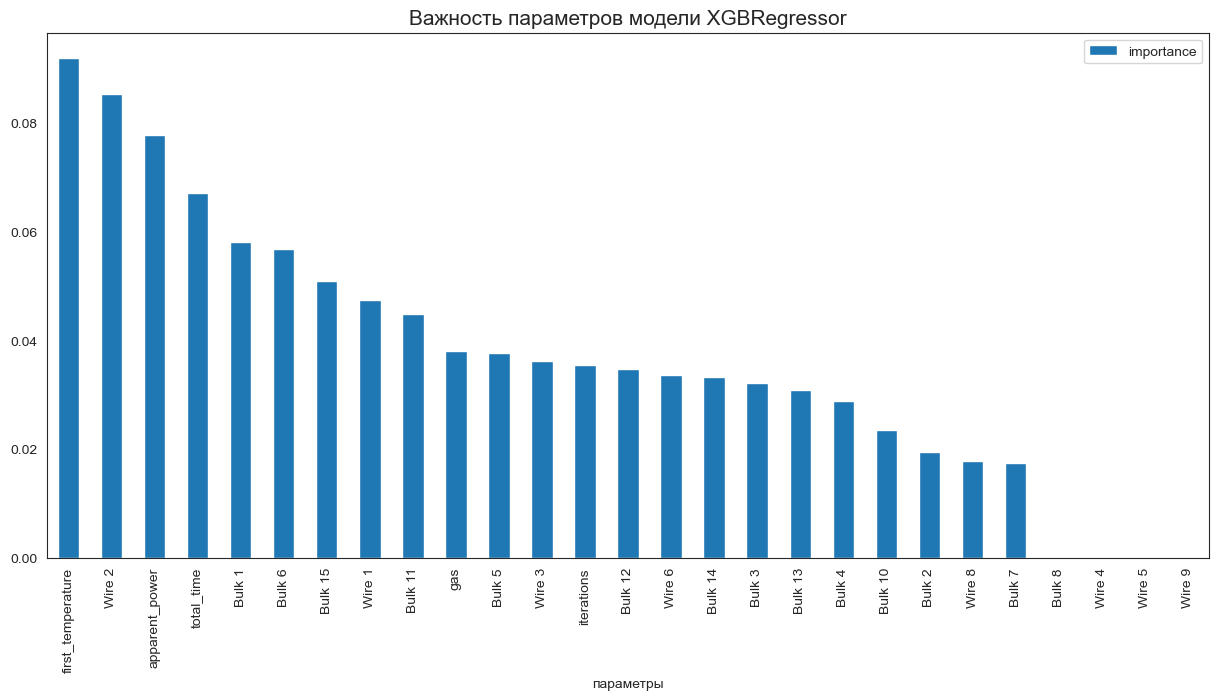

In [121]:
importance_lgbm = (pd.DataFrame({'feature': features, 'importance': model_xgb.feature_importances_}).
                       sort_values(by='importance', ascending=False).reset_index())

plt.figure(figsize=(15, 15))
plt.subplot(211)           
importance_lgbm.plot(kind = 'bar', x='feature', y='importance', ax=plt.gca(), sharex=False)
plt.xlabel('параметры')
plt.title('Важность параметров модели XGBRegressor', fontsize=15)
plt.show()


<div style="color: #000000;padding: 12px; text-align: justify; border: 4px solid #4BF1B2">
- Most important features: first_temperature, apparent_power и wire_2  <br>

</div>

## <b><span style='color:#761D80'>7 |</span><span style='color:#761D80'> Conclusions </span></b>

**<span style="color:#6C91BF;font-size:100%">The aim of the work</span>** was to build a model that predicts steel temperature to optimise the production costs of a steel mill. 

1. The project involved exploratory data analysis. As a result of which data preparation, feature selection, including the creation of new features that were used to train the models, was carried out. The final dataset consisted of **<span style="color:#6C91BF;font-size:100%">2470 rows и 27 features.</span>** 

<span> </span>

2. The performance of the following **<span style="color:#6C91BF;font-size:100%">machine learning models</span>** was evaluated:
    * RidgeRegressor
    * RandomForestRegressor
    * LightGBMRegressor
    * XGBRegressor
    
    Next, the hyperparameters were selected using the library `Optuna`
<span> </span>

3. The next step was to validate the performance of **<span style="colour:#6C91BF;font-size:100%">neural network</span>** with three linear layers and ReLu activation function (loss function - MSELoss, optimiser - AdamW). It showed good results on validation, but when the model was tested on a test sample, the error value turned out to be too large.

<span> </span>

4. It was decided to use the **<span style="colour:#6C91BF;font-size:100%">XGBRegressor</span>** model as the final model, it is not much inferior to the neural network in quality, as well as simpler and more interpretable. 

The features that contributed most to the model predictions were: first_temperature, apparent_power и wire_1

**<span style="color:#6C91BF;font-size:130%">On the test sample, the model showed the result MAE: 6.653</span>**

*How to improve the model*

* ask the customer for the temperature measurement error, the range of values that are considered normal for use
* add temperature values at all stages of production (the sequence of actions with the melt has a high probability of affecting both the result and energy consumption). This can then also be used to predict intermediate temperatures.
